<a href="https://colab.research.google.com/github/mz-zarei/CGAN-EB/blob/main/CGAN_EB_Simulation_HSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libs**

In [ ]:
import nbeb
import importlib
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from scipy import stats
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Activation
from keras import activations
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ELU, ReLU, concatenate
from keras.layers import Dropout
from matplotlib import pyplot
from keras import Input, Model
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


seed = 42


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Define Functions**

In [105]:

#####################################
###=== CGAN training Functions ===###
#####################################
# define the standalone discriminator model
def define_discriminator(in_shape=(1,)):
    y = Input(shape=in_shape, dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    label = Input(shape=(x_size,))
    label_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(label)

    concat = concatenate([y_output, label_output])
    concat = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(concat)
    concat = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(concat)
    validity = Dense(1, activation="sigmoid", kernel_initializer=random_uniform)(concat)

    model = Model(inputs=[y, label], outputs=validity)

    # compile model
    opt = Adam(learning_rate=dis_lr, beta_1=0.5, decay=dis_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, in_shape=(x_size,)):
    x = Input(shape=in_shape, dtype='float')
    x_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(x)

    noise = Input(shape=(latent_dim,))
    noise_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(noise)

    concat = concatenate([x_output, noise_output])

    output = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(concat)
    output = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(40, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(1, activation="relu", kernel_initializer=random_normal)(output)

    model = Model(inputs=[noise, x], outputs=output)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get output from the generator model
    gen_output = g_model.output
    # connect output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=gen_lr, beta_1=0.5, decay=gen_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training set
def load_real_samples(x_train,y_train):

    trainX = x_train.to_numpy()
    trainY = y_train.to_numpy()

    return [trainX, trainY]

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset[0].shape[0], n_samples)
    # retrieve selected images
    X_labels, y = dataset[0][ix], dataset[1][ix]
    # generate 'real' class labels (1)
    real = ones((n_samples, 1))
    return [y, X_labels], real

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples) #randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    idx = np.random.randint(0, x_train.shape[0], n_samples)
    X_labels = dataset[0][idx]
    return [z_input, X_labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, X_labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    samples = generator.predict([z_input, X_labels_input])
    # create class labels
    fake = zeros((n_samples, 1))
    return [samples, X_labels_input], fake

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='Dis loss real')
    pyplot.plot(d2_hist, label='Dis loss fake')
    pyplot.plot(g_hist, label='Gen loss')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = './generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    d1_hist, d2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [y_real, X_labels_real], real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([y_real, X_labels_real], real)
            # generate 'fake' examples
            [y_fake, X_labels], fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([y_fake, X_labels], fake)
            # prepare points in latent space as input for the generator
            [z_input, X_labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, X_labels_input], y_gan)

        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        # evaluate the model performance, sometimes
        if (i+1) % 100 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            print('Epoch: %d, dLoss real = %.3f, dLoss fake = %.3f, gLoss = %.3f' % (i+1, d_loss1, d_loss2, g_loss))
    plot_history(d1_hist, d2_hist, g_hist)
    return d1_hist, d2_hist, g_hist

# predict y given x
def predict_by_GAN(generator, xtest):
    noise = np.random.normal(0, 1, (xtest.shape[0], 1))
    ypred = generator.predict([noise, xtest])
    ypred[ypred<0] = 0
    return np.array(ypred)

# predict n_samples of y for each x test
def sample_from_GAN(GAN, xtest, n_samples):
    y_samples_gan = predict_by_GAN(GAN, xtest)
    for i in range(n_samples - 1):
        ypred_gan = predict_by_GAN(GAN, xtest)
        y_samples_gan = np.hstack([y_samples_gan, ypred_gan])
    median = []
    mean = []
    Var = []
    for j in range(y_samples_gan.shape[0]):
        median.append(np.median(y_samples_gan[j, :]))
        mean.append(np.mean(y_samples_gan[j, :]))
        Var.append(np.var(y_samples_gan[j, :]))
    return np.array(median).reshape(1,-1)[0], np.array(Var).reshape(1,-1)[0] , np.array(mean).reshape(1,-1)[0], y_samples_gan



#####################################
###=== Evaluation Tests Functions ===###
#####################################

# False identification test for top i% hotspots
def FI(results, i):
    nb_test = 1-results[(results['trueRank'] > 1- i) & (results['NB_rank'] > 1- i)].count()[0]/results[(results['trueRank'] > 1- i)].count()[0]
    gan_test = 1-results[(results['trueRank'] > 1- i) & (results['CGAN_rank'] > 1- i)].count()[0]/results[(results['trueRank'] > 1- i)].count()[0]
    if nb_test==0:
        out = round((nb_test - gan_test)/1*100,3)
    else:
        out = round((nb_test - gan_test)/nb_test*100,3)
    return round(nb_test,3), round(gan_test,3), round(out,3)

# Poisson Mean Difference Test
def PMD(results,i):
    nb_test = (results[results['trueRank'] > 1-i]['Lambda'].mean() - results[results['NB_rank'] > 1-i]['Lambda'].mean())/results[results['trueRank'] > 1-i]['Lambda'].mean()
    gan_test = (results[results['trueRank'] > 1-i]['Lambda'].mean() - results[results['CGAN_rank'] > 1-i]['Lambda'].mean())/results[results['trueRank'] > 1-i]['Lambda'].mean()
    
    if nb_test==0:
        out = round((nb_test - gan_test)/1*100,3)
    else:
        out = round((nb_test - gan_test)/nb_test*100,3)
    return round(nb_test,3), round(gan_test,3), round(out,3)

# Rank Difference Error
def RD(results, i):
    nb_test = results[(results['trueRank'] > 1- i)]['trueRank'].sum() - results[(results['NB_rank'] > 1- i)]['trueRank'].sum()
    gan_test = results[(results['trueRank'] > 1- i)]['trueRank'].sum() - results[(results['CGAN_rank'] > 1- i)]['trueRank'].sum()
    if nb_test==0:
        out = round((nb_test - gan_test)/1*100,3)
    else:
        out = round((nb_test - gan_test)/nb_test*100,3)
    return round(nb_test,3), round(gan_test,3), round(out,3)

# Mean abs percentage error
def MAPE(actual, predicted):
    res = np.empty(len(actual))
    for j in range(len(actual)):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return round(np.mean(np.abs(res)),3)



# **Load Real Data**

In [ ]:
realDataPath = '/content/drive/MyDrive/GAN_regression/ganRegression/UrbanFreeWay4laneDivided.xlsx'
WA_data = pd.read_excel(realDataPath)
WA_data = WA_data[(WA_data["year"] == 2012)]
WA_data.sort_values('ID', inplace=True)
WA_data = WA_data.reset_index(drop=True)
WA_data['log_AADT'] = np.log(WA_data["AADT"])

x_features = ['MEDWID','RSHL_WD2','log_AADT']
x_data = WA_data[x_features].astype(np.float)
WA_data.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


,LSHLDWID,LSHL_WD2,MEDWID,NO_LANES,RSHLDWID,RSHL_WD2,SEG_LNG,lanewid,AADT,year,RSW_r,LSW_r,rodwycls,PDO,Fatal,Injury,FI,TotalCrash,log_AADT
count,3085.000000,3085.000000,3085.000000,3085.0,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.0,3085.000000,3085.000000,3085.0,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000,3085.000000
mean,2.146191,2.224959,40.073258,4.0,8.551702,8.447326,0.083747,12.748460,44424.979254,2012.0,8.499514,2.185575,1.0,0.505024,0.001621,0.214263,0.215883,0.720908,10.522107
std,2.468942,2.553315,41.610687,0.0,3.551411,3.537766,0.118677,2.106657,26967.510746,0.0,3.339193,2.395346,0.0,1.381409,0.040232,0.757019,0.757629,1.975425,0.620864
min,0.000000,0.000000,2.000000,4.0,0.000000,0.000000,0.010000,11.000000,4328.000000,2012.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.372861
25%,0.000000,0.000000,16.000000,4.0,10.000000,10.000000,0.020000,12.000000,24315.000000,2012.0,9.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.098849
50%,0.000000,0.000000,40.000000,4.0,10.000000,10.000000,0.040000,12.000000,40808.000000,2012.0,10.000000,2.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.616633
75%,4.000000,4.000000,48.000000,4.0,10.000000,10.000000,0.100000,12.000000,58206.000000,2012.0,10.000000,4.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,10.971744
max,22.000000,20.000000,750.000000,4.0,24.000000,22.000000,2.020000,24.000000,170716.000000,2012.0,22.000000,20.000000,1.0,29.000000,1.000000,17.000000,17.000000,46.000000,12.047757


# **Simulate Crash Data**

In [152]:
# Parameters
alpha, constant, constant_nonlinear = 0.836, -14, -4.3
data_size = int(3085)
coefs = [0.002, -0.0627, 1.33]

# experiment (1): make linear simulated
simulated_data = nbeb.simulateCrashData_X(x_data, coefs, data_size = data_size, error_mean=1, error_var=alpha, constant=constant)
simulated_data['ID'] = simulated_data.index
simulated_data.to_excel('HSIS_simulated.xlsx')
y_simulated = simulated_data['Obs']
x_simulated = simulated_data[x_features]

# experiment (2): make non-linear simulated
x_data_nonLinear = pd.DataFrame()
x_data_nonLinear['MEDWID'] = x_data['MEDWID']**0.5
x_data_nonLinear['RSHL_WD2'] = x_data['RSHL_WD2']**0.5
x_data_nonLinear['log_AADT'] = x_data['log_AADT']**0.5
simulated_data_nonLinear = nbeb.simulateCrashData_X(x_data_nonLinear, coefs, data_size = data_size, error_mean=1, error_var=alpha, constant=constant_nonlinear)
simulated_data_nonLinear['ID'] = simulated_data_nonLinear.index

simulated_data_nonLinear['MEDWID'] = simulated_data_nonLinear['MEDWID'] ** 2
simulated_data_nonLinear['RSHL_WD2'] = simulated_data_nonLinear['RSHL_WD2'] ** 0.5
simulated_data_nonLinear['log_AADT'] = simulated_data_nonLinear['log_AADT'] ** 2

simulated_data_nonLinear.to_excel('HSIS_simulated_NL.xlsx')
y_simulated_nonLinear = simulated_data_nonLinear['Obs']
x_simulated_nonLinear = simulated_data_nonLinear[x_features]


# ax = plt.hist(simulated_data['Obs'])
print(simulated_data.describe())
print(simulated_data_nonLinear.describe())


            MEDWID     RSHL_WD2     log_AADT          Obs       Lambda  \
count  3085.000000  3085.000000  3085.000000  3085.000000  3085.000000   
mean     40.073258     8.447326    10.522107     0.887196     0.866729   
std      41.610687     3.537766     0.620864     1.534170     1.261372   
min       2.000000     0.000000     8.372861     0.000000     0.000421   
25%      16.000000    10.000000    10.098849     0.000000     0.173899   
50%      40.000000    10.000000    10.616633     0.000000     0.452424   
75%      48.000000    10.000000    10.971744     1.000000     1.037757   
max     750.000000    22.000000    12.047757    17.000000    14.761238   

                ID  
count  3085.000000  
mean   1542.000000  
std     890.707116  
min       0.000000  
25%     771.000000  
50%    1542.000000  
75%    2313.000000  
max    3084.000000  
            MEDWID     RSHL_WD2     log_AADT          Obs       Lambda  \
count  3085.000000  3085.000000  3085.000000  3085.000000  3085.000000

# **Fit NB model**

In [167]:
experiment = 'non-linear'

## develop NB model with simulated data
if experiment == 'linear':
    SimulatedData = pd.read_excel('/content/HSIS_simulated.xlsx')
    # SimulatedData_test = pd.read_excel('/content/HSIS_simulated_test.xlsx')
else:
    SimulatedData = pd.read_excel('/content/HSIS_simulated_NL.xlsx')
    # SimulatedData_test = pd.read_excel('/content/HSIS_simulated_NL_test.xlsx')

y_train = SimulatedData['Obs']
x_train = SimulatedData[x_features]


significant_features = nbeb.forward_regression(SimulatedData, x_features, y_name='Obs', threshold_in=0.05, verbose=False)
NB_model, alpha  = nbeb.fitNB(SimulatedData, significant_features, y_name='Obs')
y_pred_NB = NB_model.predict(sm.add_constant(SimulatedData[significant_features]))


result = pd.DataFrame()
result['ID'] = SimulatedData['ID']
result['Alpha'] = alpha
result['AADT'] = np.exp(SimulatedData['log_AADT'])
result['yPredNB'] = y_pred_NB
result['Lambda'] = SimulatedData['Lambda']
result['y'] = SimulatedData['Obs']

print(NB_model.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


               Results: Generalized linear model
Model:              GLM              AIC:            8034.6189  
Link Function:      log              BIC:            -21647.5744
Dependent Variable: Obs              Log-Likelihood: -4014.3    
Date:               2022-04-18 22:42 LL-Null:        -4027.3    
No. Observations:   3085             Deviance:       3114.2     
Df Model:           2                Pearson chi2:   3.11e+03   
Df Residuals:       3082             Scale:          1.0000     
Method:             IRLS                                        
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
const        -1.8425    0.4336  -4.2492  0.0000  -2.6924  -0.9926
log_AADT      0.1775    0.0406   4.3760  0.0000   0.0980   0.2570
RSHL_WD2     -0.0991    0.0395  -2.5060  0.0122  -0.1765  -0.0216



# **Train CGAN Model**

>Accuracy real: 37%, fake: 51%
Epoch: 100, dLoss real = 0.697, dLoss fake = 0.689, gLoss = 0.700
>Accuracy real: 49%, fake: 52%
Epoch: 200, dLoss real = 0.696, dLoss fake = 0.690, gLoss = 0.701
>Accuracy real: 48%, fake: 54%
Epoch: 300, dLoss real = 0.698, dLoss fake = 0.696, gLoss = 0.694
>Accuracy real: 54%, fake: 58%
Epoch: 400, dLoss real = 0.702, dLoss fake = 0.695, gLoss = 0.702
>Accuracy real: 73%, fake: 42%
Epoch: 500, dLoss real = 0.691, dLoss fake = 0.692, gLoss = 0.695
>Accuracy real: 53%, fake: 46%
Epoch: 600, dLoss real = 0.695, dLoss fake = 0.689, gLoss = 0.693
>Accuracy real: 48%, fake: 54%
Epoch: 700, dLoss real = 0.699, dLoss fake = 0.679, gLoss = 0.710
>Accuracy real: 52%, fake: 48%
Epoch: 800, dLoss real = 0.691, dLoss fake = 0.702, gLoss = 0.693
>Accuracy real: 56%, fake: 47%
Epoch: 900, dLoss real = 0.697, dLoss fake = 0.669, gLoss = 0.714
>Accuracy real: 75%, fake: 29%
Epoch: 1000, dLoss real = 0.682, dLoss fake = 0.699, gLoss = 0.722


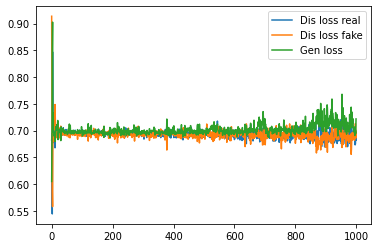

In [168]:

# Sclaing feature vector
scaler = StandardScaler().fit(x_data)
x_data_scaled = pd.DataFrame(scaler.transform(SimulatedData[x_features]))
x_data_scaled_test = pd.DataFrame(scaler.transform(SimulatedData_test[x_features]))
x_train = x_data_scaled

kerner_initializer = keras.initializers.he_normal(seed=seed)
random_uniform = keras.initializers.RandomUniform(seed=seed)
random_normal = keras.initializers.RandomNormal(seed=seed)
latent_dim, x_size = 1, 3
activation = "elu"

gen_lr, dis_lr, gen_dec, dis_dec, n_epochs, n_batch = 0.001, 0.001, 0, 0, 1000, int(200)  

# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(x_train,y_train)
# # train model
d1_hist, d2_hist, g_hist = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

# **Compute EB Estimates and Compare Performance**


In [171]:
sample_size = 100

# Load GAN model
GANpath = './generator_model_1000.h5'
GAN = keras.models.load_model(GANpath , custom_objects={'LeakyReLU': LeakyReLU(), 'Activation': Activation(activations.exponential), 'layers':keras.layers})

y_pred_gan_median,  y_pred_gan_var, y_pred_gan_mean, predictions = sample_from_GAN(GAN, np.array(x_data_scaled), sample_size)
result['yPredGAN'] = y_pred_gan_mean
result['yVarGAN'] = y_pred_gan_var

# Compute true ranking
result['trueRank'] = result['Lambda'].rank(pct=True)

# Compute NB and CGAN ranking
result['w_nb'] = 1/(result['yPredNB']*result['Alpha']+1)
result['w_cgan'] = result['yPredGAN']/(result['yPredGAN'] + result['yVarGAN'])
result.loc[result['w_cgan'] > 1,'w_cgan'] = 1
result['w_cgan'].fillna(1, inplace=True)

result['NB_EB'] = (result['yPredNB']*result['w_nb']+result['y']*(1-result['w_nb']))
result['CGAN_EB'] = (result['yPredGAN']*result['w_cgan']+result['y']*(1-result['w_cgan']))

result['NB_rank'] =  result['NB_EB'].rank(pct=True)
result['CGAN_rank'] =  result['CGAN_EB'].rank(pct=True)

In [172]:
_# FI  and RD test
for i in [0.025, 0.05, 0.075, 0.10]:
    nb_FI, gan_FI, relDif_FI = FI(result, i)
    nb_PMD, gan_PMD, relDif_PMD = PMD(result, i)
    nb_RD, gan_RD, relDif_RD = RD(result, i)

    print(f"FI top {i*100}% HS for NB: {nb_FI} and CGAN: {gan_FI}")
    print(f"PMD top {i*100}% HS for NB: {nb_PMD} and CGAN: {gan_PMD}")
    # print(f"RD top {i*100}% HS for NB: {nb_RD} and CGAN: {gan_RD}")
    print("="*50)

# MAPE test
nb_mape = MAPE(result['Lambda'], result['NB_EB'])
cgan_mape = MAPE(result['Lambda'], result['CGAN_EB'])

print(f"MAPE for NB: {nb_mape} and CGAN: {cgan_mape}")

FI top 2.5% HS for NB: 0.628 and CGAN: 0.641
PMD top 2.5% HS for NB: 0.253 and CGAN: 0.278
FI top 5.0% HS for NB: 0.561 and CGAN: 0.574
PMD top 5.0% HS for NB: 0.235 and CGAN: 0.247
FI top 7.5% HS for NB: 0.509 and CGAN: 0.543
PMD top 7.5% HS for NB: 0.208 and CGAN: 0.246
FI top 10.0% HS for NB: 0.482 and CGAN: 0.479
PMD top 10.0% HS for NB: 0.211 and CGAN: 0.213
MAPE for NB: 2.491 and CGAN: 2.02
